# Text Sentiment Classification with Transformer

## Overview

This task is to identifying opinions in text and labeling them as positive, negative, or neutral.

We fine-tune a pre-trained language model (BERT) to predict thesentiment of given tweet.

##  Versions of packages
`python 3.8.11`, `torch==1.8.2`, `torchvision==0.9.2` and `transformers==4.8.2`.

In [2]:
import sys
import torch
import torchvision
import transformers
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)
print('transformers', transformers.__version__)

python 3.7.12 (default, Sep 10 2021, 00:21:48) 
torch 1.10.0+cu111
torchvision 0.11.1+cu111
transformers 4.15.0


In [1]:
# !pip install transformers

     |████████████████████████████████| 3.4 MB 12.1 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 3.3 MB 47.7 MB/s 
     |████████████████████████████████| 895 kB 49.6 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Loading Model and Data

In [17]:
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification

bert_type = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_type)
# create a Bert-extended task (classification)
model = BertForSequenceClassification.from_pretrained(bert_type)

# finetune from the output from bert to your task
model.classifier = nn.Linear(768, 3, bias=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
# model.eval()

## Dataset
We use `twitter_sentiment`dataset.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !unzip -qq ./drive/MyDrive/twitter_sentiment.zip

In [18]:
# Utility function to extract text and label from csv file
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []
    
    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path) as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [23]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode
        
        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list
    
    def __getitem__(self, idx):
        text = torch.tensor(self.text_list[idx])
        mask = torch.tensor(self.mask_list[idx])
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

In [24]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1464 datas
mode test has 2928 datas


In [25]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0])
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t))

token ['[CLS]', '@', 'united', 'sat', 'at', 'airport', 'for', '5', 'hr', '##s', 'still', 'sitting', 'at', 'gate', '.', '.', 'sigh', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
token to s [CLS] @ united sat at airport for 5 hrs still sitting at gate . . sigh [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [26]:
device = torch.device('cuda')

from torch import nn
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## Utility Function

In [27]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

In [28]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    acc = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)
        
        # Testing
        optimizer.zero_grad()  
        outputs = model(text, mask)
        pred = outputs.logits
        loss = criterion(pred, label)
        acc = accuracy(pred, label)

      
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    acc = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        # Training
        outputs = model(text, mask)
        pred = outputs.logits
        loss = criterion(pred, label)
        acc = accuracy(pred, label)


        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# Monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

## Start Training

In [35]:
#Hyper-parameters
max_epoch = 1
log_interval = 1
best_acc = 0


m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)
    
    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))
    
    m.update(train_loss, train_acc, val_loss, val_acc)
    
    # model checkpoint
    torch.save(model.state_dict(), 'ckpts/e{}.pt'.format(epoch))
    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

  0%|          | 0/161 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


Epoch 1 train_loss: 0.0009445083953925844 train_acc: 0.9830210772833724
Epoch 1 val_loss:  0.02213504549136253 val_acc : 0.825136612021858
---------- e 1 save best model ----------


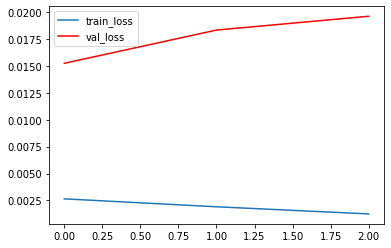

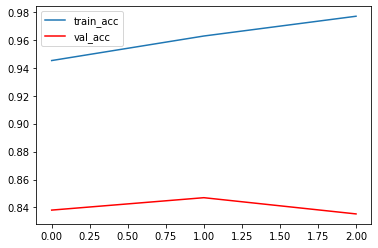

In [33]:
m.plot()

## Prediction

In [31]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data, total=len(test_data)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

  0%|          | 0/92 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 92/92 [00:19<00:00,  4.62it/s]
